# Adaptive Clustering based Intrusion Detection


## Imports

In [8]:
#!/usr/bin/env python

__author__ = "Alec F."
__license__ = "GPL"
__version__ = "1.0.1"


import os
import sys
import csv

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from core.models.network import AdaptiveClustering
from core.utils.misc import extend_dataset
from core.utils import Dataset

import json

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import pickle as pkl

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from torch.utils.data import DataLoader

from core.models.RandomForest import RandomForest
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support as prf, accuracy_score

from pprint import pprint

from codecarbon import track_emissions
from datetime import datetime
import time


## Helpers

We use these helpers functions throughout all our experiments for simplify our main code and improve its readability. In all our experiments, our datasets are separated to approximately obtain a 70/30 train-test split from randomly sampled data. We use the pickle library to save our trained model and defined a set of metrics that are commonly used for classification tasks.

In [2]:
def load_dataset(dataset_path):
    global categories
    if not os.path.exists(dataset_path):
        print(f"Dataset not found: {dataset_path}")
        sys.exit(1)

    df = pd.read_csv(dataset_path, index_col=False, sep=",")

    
    # For binary classification, uncomment the following line
    df['Label.'] = np.where(df['Label.'] == 0, "Normal", "Attack")

    
    train_test_split = .3
    msk = np.random.rand(len(df)) < train_test_split
    train_df = df[msk]
    test_df = df[~msk]

    return train_df, test_df, df


def save_model(rf, filename):
    with open(filename, 'wb') as f:
        pkl.dump(rf, f)


def load_model(filename):
    with open(filename, 'rb') as f:
        m = pkl.load(f)
    return m


class metrics(object):

    def __init__(self, tp=None, tn=None, fp=None, fn=None):
        super(metrics, self).__init__()

        self.tp, self.tn, self.fp, self.fn = tp, tn, fp, fn

        self.metrics = {}

    def accuracy(self):
        return (self.tp + self.tn) / (self.tp + self.tn + self.fp + self.fn)

    def detection_rate(self):
        return self.tp / (self.tp + self.fn)

    def false_alarm_rate(self):
        return self.fp / (self.fp + self.tn)

    def precision(self):
        return self.tp / (self.tp + self.fp)

    def f1(self):
        prec = self.precision()
        rec = self.detection_rate()
        return 0 if (prec + rec) == 0 else 2 * (prec * rec) / (prec + rec)

    def get_metrics(self):
        self.metrics = {"Acc": self.accuracy(), "DR/Recall": self.detection_rate(), "FAR": self.false_alarm_rate(),
                        "PRECISION": self.precision(), "F1 SCORE": self.f1()}
        return self.metrics

## Adaptive Clustering - training function

We train our Adaptive Clustering network by following the exact settings provided in the paper.
However, we also implement an early stop mechanism allowing us to stop the training as soon as we achieve an acceptable loss.

In [3]:
@track_emissions(tracking_mode='process')
def train(X, y,j,dic_loss, lr=1e-4):

    dic_loss[f"entrainement_{j}"] = {}

    batch_size = 1024
    print("Adaptive training...")
    model_ = AdaptiveClustering(encoder_dims=[500, 150, 50], n_kernels=len(categories), kernel_size=10)
    model_.train()


    ds = Dataset(X, y)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=8)

    n_epoch = 4
    optimizer = None

    for i in range(n_epoch):
        iteration_losses = []
        
        for x, labels_ in dl:
            model_.zero_grad()
            _ = model_(x, labels_)
            if optimizer is None:
                optimizer = torch.optim.Adam(model_.parameters(), lr=lr)

            loss = model_.loss()
            loss_value = loss.item()

            iteration_losses.append(loss_value)

            loss.backward()
            optimizer.step()
        dic_loss[f"entrainement_{j}"][f"epoch_{i}"] = iteration_losses
        print(f"Iteration {i} | Loss {np.mean(iteration_losses)}")

    model_.eval()
    return model_

## Variables

Here we define some global variables to locate our datasets and point to our results directory.

In [9]:
root_path = './'

dataset_path = root_path + 'datasets/KDD/kddcup_corrige.csv'


results_path = root_path + f'results_150/'
if not os.path.exists(results_path):
    os.mkdir(results_path)

In [10]:
model_path = results_path + 'trained_model.pkl'
separator = "-"*50

## Dataset
### Loading dataset

We load the preprocessed dataset as a pandas data frame and show the first few rows.

In [6]:
print(separator)
print("Loading dataset...")

train_df, test_df, df = load_dataset(dataset_path)
print("Done loading dataset")


--------------------------------------------------
Loading dataset...
Done loading dataset


In [7]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Label.
0,0,0,0,0,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,Attack
1,0,0,0,0,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,Normal
2,0,0,0,0,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,Normal
3,0,0,0,0,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,Normal
4,0,0,0,0,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,Normal


### Preparing the data

We prepare the features to be in the correct format for our Adaptive Clustering network and the Random Forest Classifier.

The labels are separated from the training features and the order of the categories are kept track of in order to use them in the same order when evaluating the model on the testing set.

In [8]:
if os.path.exists(model_path + ".categories"):
    print(separator)
    print("Loading categories...")
    with open(model_path + ".categories", "r") as f:
        categories = json.load(f)
        print(f"categories loaded: {model_path}.categories")
    print("Done loading categories")
else:
    print("Creating categories...")
    categories = list(set(pd.factorize(train_df['Label.'])[1].values))
    print("Done creating categories...")

print("catégories de trafic traitées:",categories)

train_df_ = train_df.drop(['Label.'], axis=1)

X = train_df_.values.tolist()
y = train_df['Label.'].values.tolist()

X = torch.FloatTensor(np.array(X))

for i, l in enumerate(y):
    y[i] = categories.index(l)

y = torch.LongTensor(np.array(y))

cats = df['Label.'].copy()
y_ = df['Label.'].values
df.drop(['Label.'], axis=1, inplace=True)

Creating categories...
Done creating categories...
catégories de trafic traitées: ['Attack', 'Normal']


## Learning

### Training the model

We train our model until we achieve an acceptable loss and export an extended dataset with the cluster centers obtained from the Adaptive Clustering network. This would allow us to not have to retrain our network for every single execution.

In [10]:
dico_temps = {}
if not os.path.exists(model_path):
    global dic_loss
    dic_loss = {}
    print("Training model...")

    debut = time.time()
    date = datetime.now()
    model = train(X, y, 0,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_0"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_1 = train(X, y, 1,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_1"] = [date,durée]

    debut = time.time()
    date = datetime.now()
    model_2 = train(X, y, 2,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_2"] = [date,durée]

    debut = time.time()
    date = datetime.now()
    model_3 = train(X, y, 3,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_3"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_4 = train(X, y, 4,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_4"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_5 = train(X, y, 5,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_5"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_6 = train(X, y, 6,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_6"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_7 = train(X, y, 7,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_7"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_8 = train(X, y, 8,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_8"] = [date,durée]
    
    debut = time.time()
    date = datetime.now()
    model_9 = train(X, y, 9,dic_loss)
    durée = time.time() - debut
    dico_temps["entrainement_9"] = [date,durée]

    # Sauvegarde du dictionnaire_loss dans un fichier
    with open(results_path+ "jeu_de_donnees/" + "dic_loss.pkl", 'wb') as file:
        pkl.dump(dic_loss, file)

    # Sauvegarde du dictionnaire_temps dans un fichier
    with open(results_path+ "jeu_de_donnees/" + "dico_temps.pkl", 'wb') as file:
        pkl.dump(dico_temps, file)

    print("Done training model")


Done training model


After obtaining the extended dataset, we train our final classifier and evaluate our Intrusion Detection System.

In [11]:
print(dico_temps)
if not os.path.exists(model_path):
    print("Training Random Forest...")
    model.classifier = RandomForest(n_estimators=200)
    model.classifier.fit(X, y)
    print("Done training Random Forest")

    print("Saving model...")
    save_model(model, model_path)
    with open(model_path+".categories", "w") as f:
        json.dump(categories, f)
        print(f"Categories saved: {model_path}.categories")
    print("Done saving model")

{'entrainement_0': [datetime.datetime(2024, 5, 14, 17, 49, 16, 416327), 878.2576229572296], 'entrainement_1': [datetime.datetime(2024, 5, 14, 18, 3, 54, 673951), 873.0415155887604], 'entrainement_2': [datetime.datetime(2024, 5, 14, 18, 18, 27, 715466), 866.2762081623077], 'entrainement_3': [datetime.datetime(2024, 5, 14, 18, 32, 53, 991674), 865.8503222465515], 'entrainement_4': [datetime.datetime(2024, 5, 14, 18, 47, 19, 841996), 872.1218636035919], 'entrainement_5': [datetime.datetime(2024, 5, 14, 19, 1, 51, 963860), 873.5474338531494], 'entrainement_6': [datetime.datetime(2024, 5, 14, 19, 16, 25, 511294), 897.6954689025879], 'entrainement_7': [datetime.datetime(2024, 5, 14, 19, 31, 23, 206763), 881.5084252357483], 'entrainement_8': [datetime.datetime(2024, 5, 14, 19, 46, 4, 715188), 953.1847107410431], 'entrainement_9': [datetime.datetime(2024, 5, 14, 20, 1, 57, 899899), 976.7933602333069]}
Training Random Forest...
Done training Random Forest
Saving model...
Categories saved: ./res

In [12]:
if os.path.exists(model_path):
    print("Loading model...")
    model = load_model(model_path)
    print("Done loading model")

Loading model...
Done loading model


### Data distributions 

Here, we print our data distributions per traffic category to verify that we have all categories of our dataset in the test set.

In [13]:
print(f"Total data distribution: {len(test_df) + len(train_df)}")
total = {}
total['total'] = len(test_df) + len(train_df)
for cat in categories:
    total[cat] = len(test_df[test_df['Label.'] == cat]) \
                   + len(train_df[train_df['Label.'] == cat])
    print(f"\t{cat}: {total[cat]}")

print(f"Training data distribution: {len(train_df)} / {len(train_df) * 100 / total['total']}%")
for cat in categories:
    c = len(train_df[train_df['Label.'] == cat])
    print(f"\t{cat}: {c} / {c*100 / total[cat]}%")
    
print(f"Testing data distribution: {len(test_df)} / {len(test_df) * 100 / total['total']}%")
for cat in categories:
    c = len(test_df[test_df['Label.'] == cat])
    print(f"\t{cat}: {c} / {c * 100 / total[cat]}%")



Total data distribution: 4898431
	Attack: 3925651
	Normal: 972780
Training data distribution: 1469587 / 30.001177928197826%
	Attack: 1177067 / 29.98399501127329%
	Normal: 292520 / 30.070519541931372%
Testing data distribution: 3428844 / 69.99882207180218%
	Attack: 2748584 / 70.0160049887267%
	Normal: 680260 / 69.92948045806862%


### Testing the model

To evaluate our model on the unseen set, we remove the labels and run our trained model on the remaining features.

In [14]:
df = test_df.drop(['Label.'], axis=1)
x = df.values.tolist()

y_hat = model.classifier.predict(x)
preds = []

for i in y_hat:
    preds.append(categories[i])

### Confusion matrix

We compute the confusion matrix to observe how well our model works on every single category in our test set.

In [15]:
print("Creating confusion matrix...")

for i, category in enumerate(categories):
    test_df['Label.'].replace(to_replace=category, value=i, inplace=True)
y_actual_ = test_df['Label.'].values.tolist()
y_actual = []
for i in y_actual_:
    y_actual.append(categories[i])

print(f"Uniques actual: {list(set(y_actual))}")
print(f"Uniques preds: {list(set(preds))}")

y_actu = pd.Series(y_actual, name='Actual')
y_pred = pd.Series(preds, name='Predicted')

df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'],
                           dropna=False, margins=False, normalize='index').round(4) * 100

df_confusion.to_csv(results_path + 'rf_confusion_matrix.csv')
print(f"Confusion matrix created and saved: {results_path}rf_confusion_matrix.csv")

Creating confusion matrix...


C:\Users\maxou\AppData\Local\Temp\ipykernel_6544\2702409728.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['Label.'].replace(to_replace=category, value=i, inplace=True)
C:\Users\maxou\AppData\Local\Temp\ipykernel_6544\2702409728.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_d

Uniques actual: ['Attack', 'Normal']
Uniques preds: ['Attack', 'Normal']
Confusion matrix created and saved: ./results_150/rf_confusion_matrix.csv


In [16]:
df_confusion

Predicted,Attack,Normal
Actual,,
Attack,100.0,0.0
Normal,0.0,100.0


As mentioned in the paper, and shown by the confusion matrix above, our approach obtains a perfect classification score over the entire test set.

### Confusion matrix heatmap

For a clearer visualization, we plot our confusion matrix as a classification ratio for all different categories and again, observe that we have a perfect classification score on every single category in the entire test set.

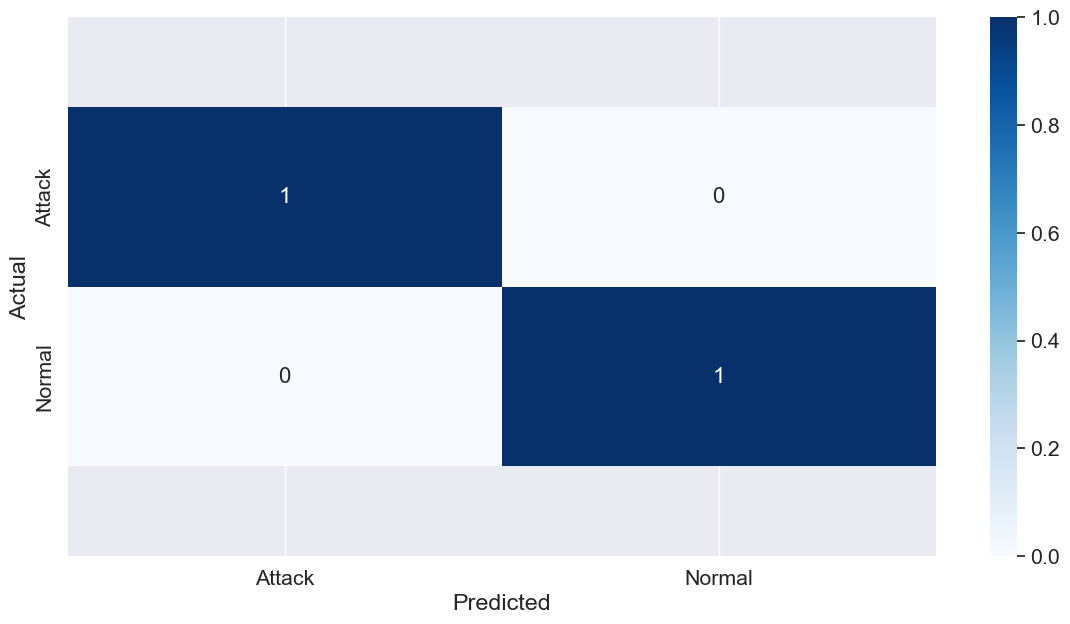

In [17]:


df_cm =  pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'],
                           dropna=False, margins=False, normalize='index').round(4)
plt.figure(figsize = (14,7))
sns.set_theme(font_scale=1.4)
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()

### Important features

We can see the degree of contribution of each feature to the classification result by using the __feature\_importances\___ attribute of the Random Forest Classifier. We see here that, as mentioned in the paper, the 10 features extracted from our Adaptive Clustering network consistute the 10 most important features for the classifier.

In [18]:
print("Calculating feature importance scores...")
importances = model.classifier.cls.feature_importances_
indices = np.argsort(importances)[-50:][::-1]  # -50 #most important features
cols = test_df.columns.values.tolist()

feature_importances_list = []
for f in range(len(indices)):
    feature_importances_list.append([indices[f], cols[indices[f]], importances[indices[f]]])

with open(results_path + "rf_feature_importance_scores.pkl", "wb") as f:
    pkl.dump(feature_importances_list, f)
    print(f"Feature importance scores saved: {results_path}rf_feature_importance_scores.pkl")

    print("")
    print("15 most important features")
    pprint(feature_importances_list[:15])
    print("Sum 15:", np.sum(importances[indices[:15]]))
    print("")

Calculating feature importance scores...
Feature importance scores saved: ./results_150/rf_feature_importance_scores.pkl

15 most important features
[[22, 'count', 0.22179171183564178],
 [2, 'service', 0.13022866594023969],
 [5, 'dst_bytes', 0.11981446632179389],
 [11, 'logged_in', 0.07651676457834965],
 [4, 'src_bytes', 0.06299769705288207],
 [1, 'protocol_type', 0.04944413715897653],
 [31, 'dst_host_count', 0.04937475349954123],
 [35, 'dst_host_same_src_port_rate', 0.04039579188614264],
 [23, 'srv_count', 0.038085466896378706],
 [28, 'same_srv_rate', 0.03705600451875995],
 [36, 'dst_host_srv_diff_host_rate', 0.03101068389853792],
 [3, 'flag', 0.026318870334639054],
 [29, 'diff_srv_rate', 0.024836292957231727],
 [30, 'srv_diff_host_rate', 0.022529932714540762],
 [34, 'dst_host_diff_srv_rate', 0.014755196169070407]]
Sum 15: 0.9451564357627259



### Performance metrics

Finally, we compute the different performance metrics on our test set. We can see here again that this approach allows us to obtain a perfect score on every single evaluation metric, making this the new state-of-the-art approach for classification tasks.

In [19]:
print("Calculating performance metrics...")
cnf_matrix = confusion_matrix(y_actual_, y_hat)
_fp = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
_fn = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
_tp = np.diag(cnf_matrix)
_tn = cnf_matrix.sum() - (_fp + _fn + _tp)

_fp = _fp.astype(float)
_fn = _fn.astype(float)
_tp = _tp.astype(float)
_tn = _tn.astype(float)

_fp = np.mean(_fp)
_fn = np.mean(_fn)
_tp = np.mean(_tp)
_tn = np.mean(_tn)

metrics_handler = metrics(tp=_tp, tn=_tn, fp=_fp, fn=_fn)
metrics_data = metrics_handler.get_metrics()

accuracy = accuracy_score(y_actual_, y_hat)
precision, recall, f_score, support = prf(y_actual_, y_hat, average='weighted')
print("Accuracy : {:0.7f}, Precision : {:0.7f}, Recall : {:0.7f}, F-score : {:0.7f}, FAR: {:0.7f}"
                                                      .format(accuracy, precision,
                                                              recall, f_score, metrics_data["FAR"]))

with open(results_path + "metrics_handler.pkl", "wb") as f:
    pkl.dump(metrics_handler, f)
    print(f"Performance metrics saved: {results_path}metrics_handler.pkl")




Calculating performance metrics...
Accuracy : 0.9999525, Precision : 0.9999525, Recall : 0.9999525, F-score : 0.9999525, FAR: 0.0000475
Performance metrics saved: ./results_150/metrics_handler.pkl


### GRAPHES



losses: [1.6559287667274476, 1.6020977020263671, 1.59279465675354, 1.5984220504760742, 1.6112077355384826, 1.5640564441680909, 1.5660743474960328, 1.540638792514801, 1.5427735090255736, 1.5361210823059082, 1.5410538077354432, 1.5474720358848573, 1.5141607403755188, 1.5141150951385498, 1.5022282958030702, 1.5037137269973755, 1.5113093614578248, 1.5066783428192139, 1.4821473836898804, 1.4762352108955383, 1.4780559062957763, 1.4663384556770325, 1.4789923906326294, 1.4644532442092895, 1.4699891328811645, 1.4482966423034669, 1.4576472878456115, 1.4671101927757264, 1.4592994093894958, 1.4474889039993286, 1.4264138102531434, 1.435026264190674, 1.4350916743278503, 1.433070755004883, 1.419313871860504, 1.41286598443985, 1.3965813875198365, 1.3936163783073425, 1.4066811442375182, 1.396961510181427, 1.3880311012268067, 1.4039325833320617, 1.3987038135528564, 1.3880443692207336, 1.3717438936233521, 1.3713091254234313, 1.3874622583389282, 1.377074909210205, 1.3765389323234558, 1.3570515394210816, 1

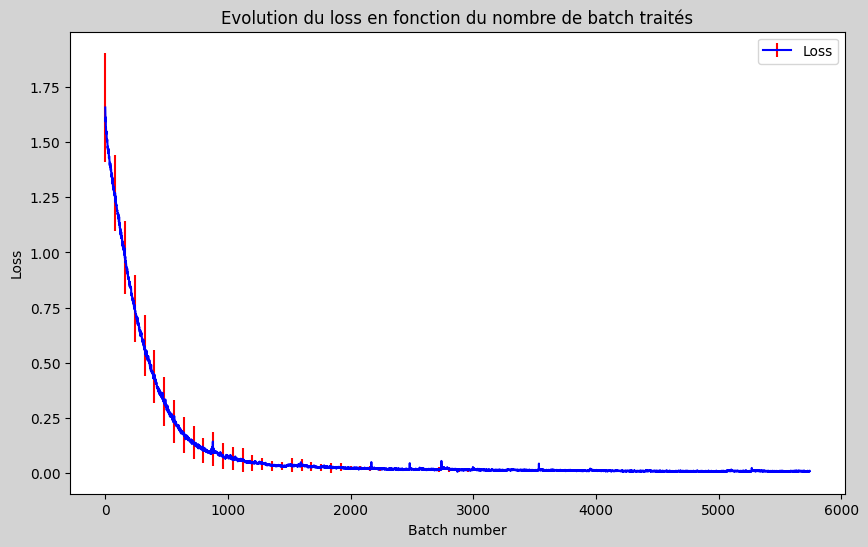

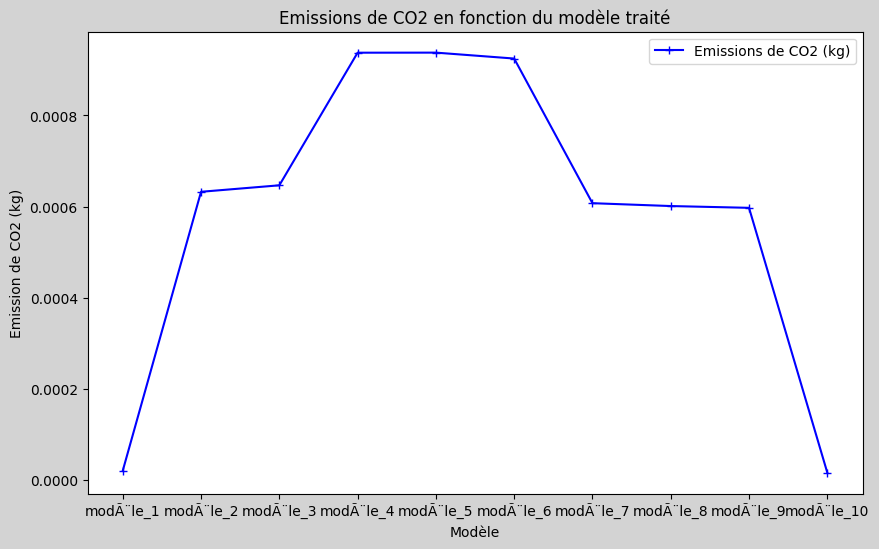

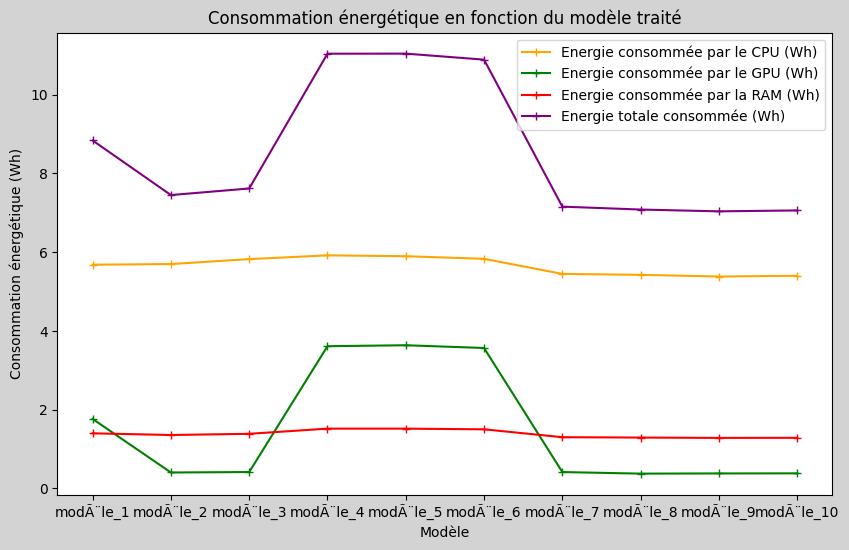

In [11]:
couleurs = ['blue','orange','green','red']

import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as st
import statistics as stat
import os
import sys

def confidence_interval(data,confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    se = st.sem(a)
    h = se * st.t.ppf((1 + confidence) / 2.,n-1)
    return h



with open(results_path+"jeu_de_donnees/dic_loss.pkl", 'rb') as file:
    dic_loss = pkl.load(file)


x = range(len(dic_loss["entrainement_1"]['epoch_0'])*4)

plt.figure(figsize=(10, 6),facecolor='lightgrey')  # Créer une seule figure

#init losses
losses = {j: [0 for i in range(len(dic_loss["entrainement_1"]["epoch_0"]))] for j in dic_loss["entrainement_1"].keys()}


#Calcul de la somme des losses pour chaque tentative et à chaque epoch
for tentative in dic_loss.keys():
    # print(tentative)
    for epoch in dic_loss[tentative].keys():
        # print(epoch)
        for v_loss in range(len(losses[epoch])):
            # print(f"loss courant: {losses[epoch][v_loss]} / somme: {dic_loss[tentative][epoch][v_loss]}")
            losses[epoch][v_loss] += dic_loss[tentative][epoch][v_loss]

#Mise à jour du dico loss
# losses = {j: [i/len(dic_loss.keys()) for i in losses[j]] for j in dic_loss["entrainement_1"].keys()}
losses = {"valeurs" : losses["epoch_0"] + losses["epoch_1"] + losses["epoch_2"] + losses["epoch_3"]}
losses = [i/len(dic_loss.keys()) for i in losses["valeurs"]]

with open(results_path+"jeu_de_donnees/moyenne_loss.pkl", 'wb') as fichier:
    pkl.dump(losses,fichier)

print("losses:",losses)

#Préparation des barres d'erreurs

std_loss = []
transfert = {i : dic_loss[i]["epoch_0"]+dic_loss[i]["epoch_1"]+dic_loss[i]["epoch_2"]+dic_loss[i]["epoch_3"] for i in dic_loss.keys()}

for i in range(len(transfert["entrainement_1"])):
    data = [transfert[j][i] for j in transfert.keys()]
    std_loss.append(confidence_interval(data))


plt.errorbar(x, losses, yerr=[std_loss[i] if (i%80==0) else 0 for i in range(len(losses))],label="Loss",color=couleurs[0], ecolor='red')
                 
#Graphe général
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.title('Evolution du loss en fonction du nombre de batch traités')
plt.legend()
plt.savefig(results_path + './courbes/loss_evolution_with_uncertainty_4epochs.png')  # Sauvegarder la figure



# with open(results_path+"jeu_de_donnees/"+"moyenne_loss.pkl", 'wb') as file:
#         pkl.dump(losses, file)
with open(results_path+"jeu_de_donnees/"+"std_loss.pkl", 'wb') as file:
        pkl.dump(std_loss, file)


#Partie émissions
plt.figure(figsize=(10, 6),facecolor='lightgrey')  # Créer une seule figure
liste_x = []
liste_emissions_y = []
liste_cpu_energy_y = []
liste_gpu_energy_y = []
liste_ram_energy_y = []
liste_total_energy_y = []

with open(results_path+"emissions.csv", "r") as csvfile:
    lecteur = csv.DictReader(csvfile, delimiter=',')
    for ligne in lecteur:
        print(ligne)
        if ligne['project_name'] != "initialisation":
            liste_emissions_y.append(float(ligne["emissions"]))
            liste_cpu_energy_y.append(float(ligne["cpu_energy"])*1000)
            liste_gpu_energy_y.append(float(ligne["gpu_energy"])*1000)
            liste_ram_energy_y.append(float(ligne["ram_energy"])*1000)
            liste_total_energy_y.append(float(ligne["energy_consumed"])*1000)
            liste_x.append(ligne['project_name'])



plt.plot(liste_x,liste_emissions_y,label="Emissions de CO2 (kg)",color="blue",marker='+')
plt.xlabel('Modèle')
plt.ylabel('Emission de CO2 (kg)')
plt.title('Emissions de CO2 en fonction du modèle traité')
plt.legend()
plt.savefig(results_path + './courbes/emission_Co2.png')

#partie consommation
plt.figure(figsize=(10, 6),facecolor='lightgrey')  # Créer une seule figure

plt.plot(liste_x,liste_cpu_energy_y,label="Energie consommée par le CPU (Wh)",color="orange",marker='+')
plt.plot(liste_x,liste_gpu_energy_y,label="Energie consommée par le GPU (Wh)",color="green",marker='+')
plt.plot(liste_x,liste_ram_energy_y,label="Energie consommée par la RAM (Wh)",color="red",marker='+')
plt.plot(liste_x,liste_total_energy_y,label="Energie totale consommée (Wh)",color="purple",marker='+')

plt.xlabel('Modèle')
plt.ylabel('Consommation énergétique (Wh)')
plt.title('Consommation énergétique en fonction du modèle traité')
plt.legend()
plt.savefig(results_path + './courbes/conso_electrique.png')

plt.show()

#Conservation des données
dico_enviro = {}
dico_enviro["emissions"] = liste_emissions_y
dico_enviro["cpu_energy"] = liste_cpu_energy_y
dico_enviro["gpu_energy"] = liste_gpu_energy_y
dico_enviro["ram_energy"] = liste_ram_energy_y
dico_enviro["total_energy"] = liste_total_energy_y
dico_enviro["liste_x"] = liste_x

with open(results_path+"jeu_de_donnees/"+"dico_enviro.pkl", 'wb') as file:
        pkl.dump(dico_enviro, file)

#ARRANGER LE CODE ICI PAR RAPPORT AU FICHIER CSV DES EMISSIONS PUIS FAIRE CELUI AVEC 50 NEURONES